<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Afib_Data_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook processes the ECG and PPG signals from MIMIC-III waveform database.
(https://archive.physionet.org/physiobank/database/mimic3wdb/matched/ ）


The Deep-ECG model is used to label the ECG, as well as PPG signals. The output of this notebook is PPG signals with 30s segements at 125 Hz, with Afib and NSR labels. The output data will be used to train a Deep-PPG model in Afib_PPG notebook.


The data cleaning and preprocessing is inspired by the following workflow, with some minor modification for our own application, where the order is:
1. Normalization
2. Segmentation
3. Flat line removal
4. Band-pass filter
5. Hampel filter

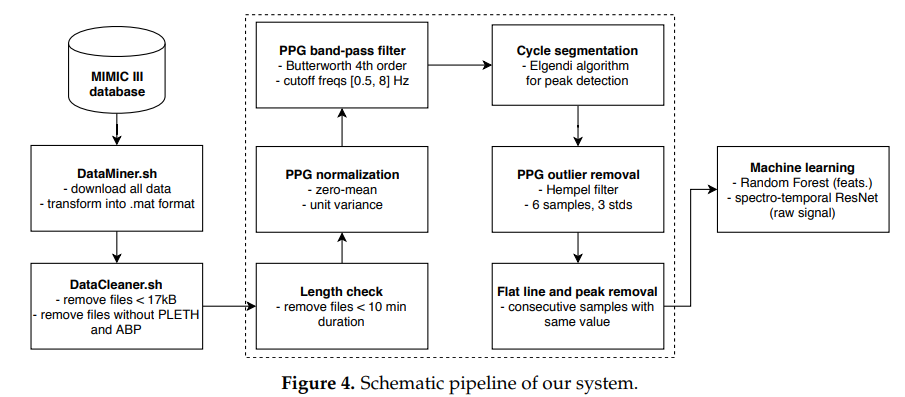

#2.Setup Environment

In [0]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import wfdb
import sklearn
import io
import pickle
import numba
from numba import jit
import tensorflow as tf

#3.Mine ECG and PPG data from WFDB

In [0]:
hd_names = []
for name in glob.glob("D:WFDB//matched/p09/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  42791 records that are bigger than 17kb


In [0]:
qualified_names = [] #a list of file names that contain both PPG and ECG Lead I waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'I' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #extact only records contrains ECG lead I and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ECG and PPG with more than 10min recording')

There are total 754 records that have both ECG and PPG with more than 10min recording


In [0]:
##use the same name for wfdb.rdrecord
##sampling freq is 125 Hz for both ECG and PPG: 
##Documentation: https://archive.physionet.org/physiobank/database/mimic3wdb/
ECG_signals = [] #create a  list to store all  ECG signals
PPG_signals = [] #create a  list to store all  PPG signals
names = []
for name in qualified_names:
  record = wfdb.rdrecord(name)

  ECG_index = record.sig_name.index('I')
  PPG_index = record.sig_name.index('PLETH')
  ECG_sig = record.p_signal.T[ECG_index]
  PPG_sig = record.p_signal.T[PPG_index]

  if np.isnan(ECG_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
    continue
  else:
    ECG_signals.append(ECG_sig)
    PPG_signals.append(PPG_sig)
    names.append(name)
print('ECG signals len:', len(ECG_signals))
print('PPG signals len:', len(PPG_signals))

ECG signals len: 417
PPG signals len: 417


In [0]:
#save ECG data
with open('D:WFDB//matched/ECG_signals_p09.pkl', "wb") as fp:
  pickle.dump(ECG_signals, fp)
#save PPG data
with open('D:WFDB//matched/PPG_signals_p09.pkl', "wb") as fp:
  pickle.dump(PPG_signals, fp)

#4.Process ECG data

Load ECG data

In [0]:
with open('D:WFDB//matched/ECG_signals_p09.pkl', "rb") as fp:
  raw_ECG_signals = pickle.load(fp)

##4.1 Apply filters

###4.1.1 Normalization

In [0]:
#normalization
from sklearn import preprocessing
norm_signals = [sklearn.preprocessing.scale(i) for i in raw_ECG_signals]

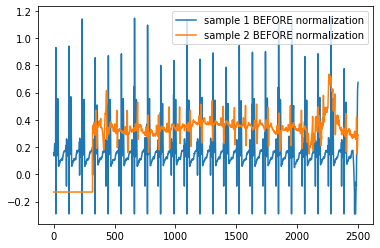

In [59]:
plt.plot(raw_ECG_signals[0][0:2500],label="sample 1 BEFORE normalization")
plt.plot(raw_ECG_signals[2][0:2500],label="sample 2 BEFORE normalization")
plt.legend()

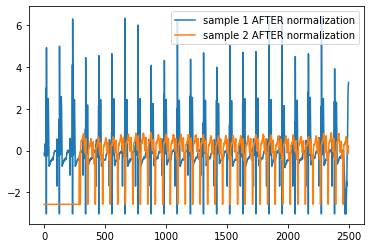

In [60]:
plt.plot(norm_signals[0][0:2500],label="sample 1 AFTER normalization")
plt.plot(norm_signals[10][0:2500],label="sample 2 AFTER normalization")
plt.legend()

### 4.1.2 Segmentation

In [0]:
def generate_segment_data(source,seg_len):
  n=0
  signals =[]
  for signal in source:
    for i in range(int(len(signal)/seg_len)):
      seg = signal[seg_len*i:seg_len*(i+1)]
      signals.append(seg)
    n+=1
#convert list into a numpy array and change its dim from (num of records, seg_len, 1) to (num of records, seg_len)
  signals = np.asarray(list(map(lambda x: np.reshape(x,3750),signals)))

  return signals

In [61]:
seg_signals = generate_segment_data(norm_signals, 3750)
print('segmented signals dim:', seg_signals.shape)

segmented signals dim: (83197, 3750)


C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


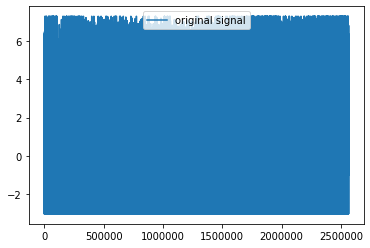

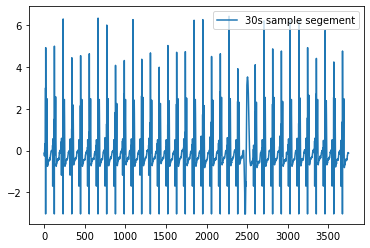

In [62]:
signals_zero = sklearn.preprocessing.scale(raw_ECG_signals[0])
plt.plot(signals_zero,label="original signal")
plt.legend()
plt.figure() 
plt.plot(seg_signals[0],label='30s sample segement')
plt.legend()

###4.1.3 Flat line removal

#### 4.1.3.1 Find the threshold 

In [0]:
#how to find the correct threshold?
#threshold can't be too big, then nosiy data will be mistakenly labeled as flat line
#threshold can't be too small, then no flat line can be detected
#one method is to use histogram of the differentce of consecutive points, in a sense
#that small changes (such as flat line) tends to have similar values to each other,
#therefore, they will group together in histogram and show up as the max peak

array([0.        , 0.        , 0.        , ..., 0.14268369, 0.06917997,
       0.06917997])

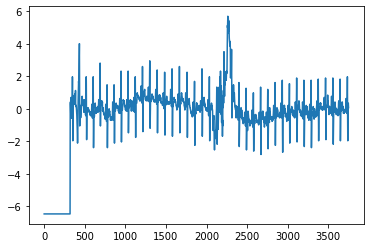

In [0]:
#take a look at one normalized example that has flat line regions
signals_one = sklearn.preprocessing.scale(raw_ECG_signals[2])
plt.plot(signals_one[:3750])
signal_diff = abs(np.diff(signals_one[:3750]))
signal_diff

threshold 0.0


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,1325,0,0,928,262,0,0,438,0,0,...,0,0,0,0,0,0,0,0,1,NaN
1,0,0.0178384,0.0356767,0.0535151,0.0713534,0.0891918,0.10703,0.124868,0.142707,0.160545,...,6.511,6.52884,6.54668,6.56451,6.58235,6.60019,6.61803,6.63587,6.65371,6.671543


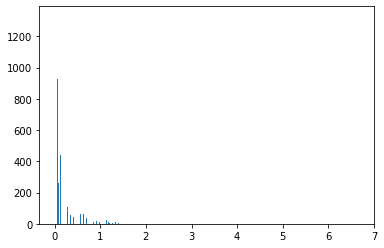

In [0]:
#plot the histogram and find the threshold
histogram = plt.hist(signal_diff,bins=int(len(signal_diff)/10)) 
histogram
max_index = np.argmax(histogram[0])
threshold = histogram[1][max_index]
print("threshold", threshold)
pd.DataFrame(histogram)[0:2]

array([0.07068652, 0.        , 0.03029422, ..., 0.        , 0.        ,
       0.        ])

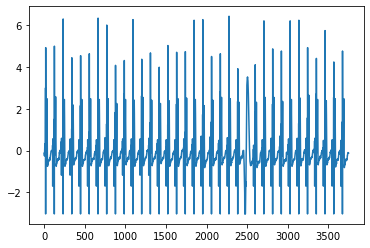

In [0]:
#take a look at another normalized example that has flat line regions
signals_two = sklearn.preprocessing.scale(raw_ECG_signals[0])
plt.plot(signals_two[:3750])
signal_diff = abs(np.diff(signals_two[:3750]))
signal_diff

threshold 0.0


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,1192,1171,294,139,3,70,82,66,20,52,...,2,2,2,1,0,1,0,0,1,NaN
1,0,0.0253262,0.0506524,0.0759786,0.101305,0.126631,0.151957,0.177283,0.202609,0.227936,...,9.24406,9.26938,9.29471,9.32004,9.34536,9.37069,9.39601,9.42134,9.44667,9.471993


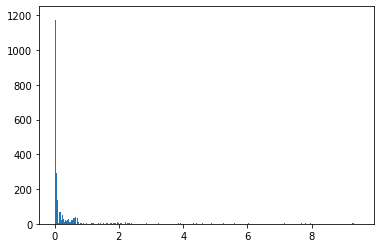

In [0]:
#plot the histogram and find the threshold
histogram = plt.hist(signal_diff,bins=int(len(signal_diff)/10))
histogram
max_index = np.argmax(histogram[0])
threshold = histogram[1][max_index]
print("threshold", threshold)
pd.DataFrame(histogram)[0:2]

By comparing the above two examples, even threshold is set to the smallest value (which is 0), normal data that has no flat line region shows 1192 points of zero signal change, which is around 1/3 of total points. That means the percentage in flat_line function should be 33% + flat line% = 45% if we accept 12% flat line region in final data

####4.1.3.2 Remove flat line signals

In [0]:
def flat_line(signals,threshold = 0, percent = .45):
  clean_signals = []
  #create a list to store the index of the removed segments, this will be used
  #to remove the PPG signals with same index
  rm_list = []
  for i in range(len(signals)):
    #use np.diff to find consecutive points: diff = [i] - [i+1]
    signal_diff = np.diff(signals[i])
    #change value less than threshold to 0, and the rest to 1
    less = abs(signal_diff) <= threshold
    more = abs(signal_diff) > threshold
    signal_diff[less] = 0
    signal_diff[more] = 1
    #calculate what percent of 0 in the signal, remove the entire signal if 
    #percentage is higher than defined percent
    zero_per = sum(signal_diff==0)/len(signal_diff)
    if zero_per < percent:
      clean_signals.append(signals[i])
    else:
      rm_list.append(i)
    
    #track the progress for impatient programmer like me
    if i%1000 == 0:
      print("Processing on", i, "th sample")

  return clean_signals,rm_list

In [63]:
clean_signals,rm_list = flat_line(seg_signals)

Processing on 0 th sample
Processing on 1000 th sample
Processing on 2000 th sample
Processing on 3000 th sample
Processing on 4000 th sample
Processing on 5000 th sample
Processing on 6000 th sample
Processing on 7000 th sample
Processing on 8000 th sample
Processing on 9000 th sample
Processing on 10000 th sample
Processing on 11000 th sample
Processing on 12000 th sample
Processing on 13000 th sample
Processing on 14000 th sample
Processing on 15000 th sample
Processing on 16000 th sample
Processing on 17000 th sample
Processing on 18000 th sample
Processing on 19000 th sample
Processing on 20000 th sample
Processing on 21000 th sample
Processing on 22000 th sample
Processing on 23000 th sample
Processing on 24000 th sample
Processing on 25000 th sample
Processing on 26000 th sample
Processing on 27000 th sample
Processing on 28000 th sample
Processing on 29000 th sample
Processing on 30000 th sample
Processing on 31000 th sample
Processing on 32000 th sample
Processing on 33000 th 

In [64]:
print('There are',len(clean_signals),'accepted segments')
print('There are',len(rm_list),'rejected segements that have flat line region more than ~10%')

There are 82181 accepted segments
There are 1016 rejected segements that have flat line region more than ~10%


In [0]:
#take the fist 50 samples to see the rejected segements
for i in range(len(rm_list[:50])):
  x = rm_list[i]
  plt.figure()
  plt.plot(seg_signals[x])

###4.1.4 Band pass filter



In [0]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [0]:
bf_ECG_signals = []
for i in range(len(clean_signals)):
  bf_ECG_signal =butter_bandpass_filter(clean_signals[i],0.2,8,125,order=3)
  bf_ECG_signals.append(bf_ECG_signal)
  if i%1000 == 0:
      print("Processing on", i, "th sample")
print("After band pass filtering, there are:", len(bf_ECG_signals), "records")

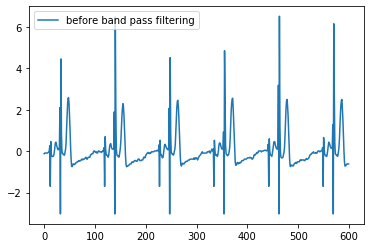

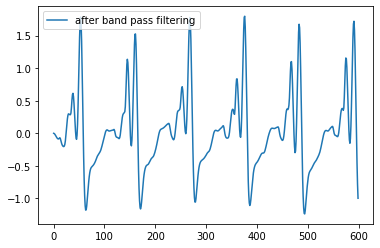

In [0]:
plt.plot(clean_signals[1][:600],label="before band pass filtering")
plt.legend()
plt.figure()
plt.plot(bf_ECG_signals[1][:600], label="after band pass filtering")
plt.legend()

###4.1.5 Hampel filter

In [0]:
#use numba to improve the speed of for loop
@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [0]:
hf_ECG_signals_num=[]
index=[]
for i in range(len(bf_ECG_signals)):
  if i%1000 == 0:
    print("hampel filering at", i+1, "th sample...")
  hf_ECG_signal_num, indices = hampel_filter_forloop_numba(bf_ECG_signals[i], 6)
  hf_ECG_signals_num.append(hf_ECG_signal_num)
  if indices != []:
    index.append([i,indices])
print("After Hample filtering, there are:", len(hf_ECG_signals_num), "records")
print("There are total", len(index),"segements identified with outliers")

In [0]:
index

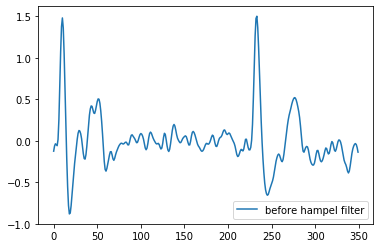

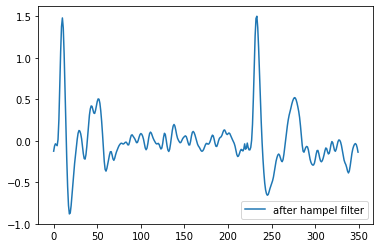

In [0]:
plt.plot(bf_ECG_signals[1020][3400:], label = "before hampel filter")
plt.legend()
plt.figure()
plt.plot(hf_ECG_signals_num[1020][3400:], label = "after hampel filter")
plt.legend()

In [0]:
with open('D:WFDB/matched/filtered_ECG_signals_p09.pkl', "wb") as fp:
  pickle.dump(hf_ECG_signals_num, fp)

#5.Process PPG data

Load PPG data

In [0]:
with open('D:WFDB//matched/PPG_signals_p09.pkl', "rb") as fp:
  raw_PPG_signals = pickle.load(fp)

##5.1 Apply filters

###5.1.1 Normalization

In [17]:
#normalization
from sklearn import preprocessing
norm_PPG_signals = [sklearn.preprocessing.scale(i) for i in raw_PPG_signals]

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:1

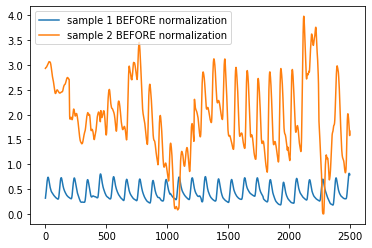

In [20]:
plt.plot(raw_PPG_signals[0][0:2500],label="sample 1 BEFORE normalization")
plt.plot(raw_PPG_signals[2][0:2500],label="sample 2 BEFORE normalization")
plt.legend()

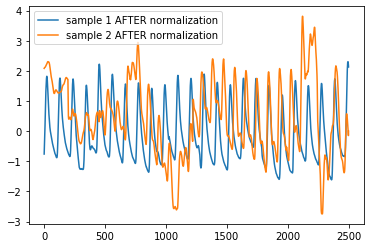

In [19]:
plt.plot(norm_PPG_signals[0][0:2500],label="sample 1 AFTER normalization")
plt.plot(norm_PPG_signals[2][0:2500],label="sample 2 AFTER normalization")
plt.legend()

###5.1.2 Segmentaion

In [26]:
seg_PPG_signals = generate_segment_data(norm_PPG_signals, 3750)
print('segmented PPG signals dim:', seg_PPG_signals.shape)

segmented PPG signals dim: (83197, 3750)


C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


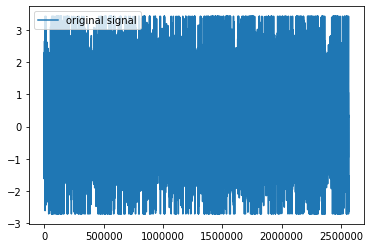

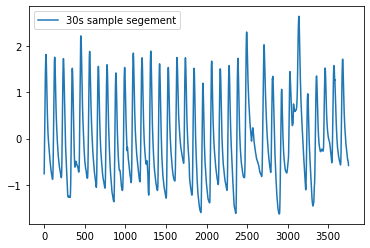

In [27]:
PPG_signals_zero = sklearn.preprocessing.scale(raw_PPG_signals[0])
plt.plot(PPG_signals_zero,label="original signal")
plt.legend()
plt.figure() 
plt.plot(seg_PPG_signals[0],label='30s sample segement')
plt.legend()

###5.1.3 Flat line removal

#### 5.1.3.1 Find the threshold 

array([0.01126795, 0.00804854, 0.00482912, ..., 0.0869242 , 0.08531449,
       0.08209508])

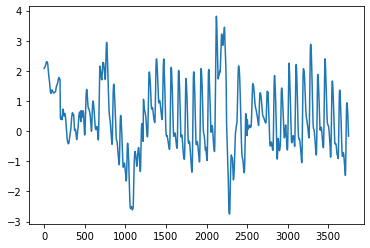

In [29]:
#take a look at one normalized example that has flat line regions
PPG_signals_one = sklearn.preprocessing.scale(raw_PPG_signals[2])
plt.plot(PPG_signals_one[:3750])
PPG_signal_diff = abs(np.diff(PPG_signals_one[:3750]))
PPG_signal_diff

threshold 0.0


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,141,102,101,124,91,121,115,115,111,94,...,0,0,0,0,0,0,0,0,1,NaN
1,0,0.00165705,0.0033141,0.00497116,0.00662821,0.00828526,0.00994231,0.0115994,0.0132564,0.0149135,...,0.604824,0.606481,0.608138,0.609795,0.611452,0.613109,0.614766,0.616423,0.61808,0.619737


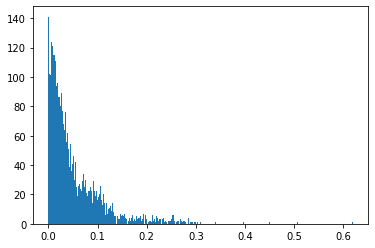

In [30]:
#plot the histogram and find the threshold
histogram = plt.hist(PPG_signal_diff,bins=int(len(PPG_signal_diff)/10)) 
histogram
max_index = np.argmax(histogram[0])
threshold = histogram[1][max_index]
print("threshold", threshold)
pd.DataFrame(histogram)[0:2]

array([0.11975393, 0.10777853, 0.10179084, ..., 0.02395079, 0.01796309,
       0.02395079])

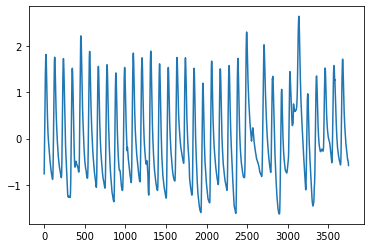

In [31]:
#take a look at another normalized example that has flat line regions
PPG_signals_two = sklearn.preprocessing.scale(raw_PPG_signals[0])
plt.plot(PPG_signals_two[:3750])
PPG_signal_diff = abs(np.diff(PPG_signals_two[:3750]))
PPG_signal_diff

threshold 0.011527116004362603


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,166,0,0,0,0,0,0,0,0,407,...,0,0,0,0,0,0,0,0,2,NaN
1,0,0.000640395,0.00128079,0.00192119,0.00256158,0.00320198,0.00384237,0.00448277,0.00512316,0.00576356,...,0.233744,0.234385,0.235025,0.235665,0.236306,0.236946,0.237587,0.238227,0.238867,0.239508


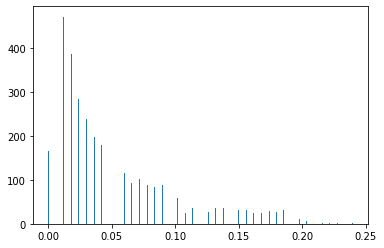

In [32]:
#plot the histogram and find the threshold
histogram = plt.hist(PPG_signal_diff,bins=int(len(PPG_signal_diff)/10))
histogram
max_index = np.argmax(histogram[0])
threshold = histogram[1][max_index]
print("threshold", threshold)
pd.DataFrame(histogram)[0:2]

By comparing the above two examples, even threshold is set to the smallest value (which is 0), normal data that has no flat line region shows 140 points of zero signal change, which is around 3% of total points. That means the percentage in flat_line function should be 3% + flat line% = 15% if we accept 12% flat line region in final data

####5.1.3.2 Find flat line PPG segs

In [0]:
PPG_clean_signals,PPG_rm_list = flat_line(seg_PPG_signals)

In [35]:
print('There are',len(PPG_clean_signals),'accepted PPG segments')
print('There are',len(PPG_rm_list),'rejected PPG segements that have flat line region more than ~10%')

There are 80767 accepted PPG segments
There are 2430 rejected PPG segements that have flat line region more than ~10%


C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


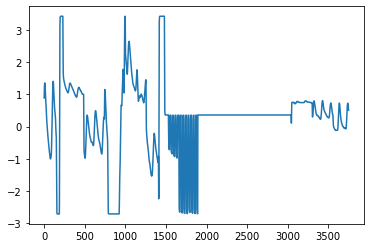

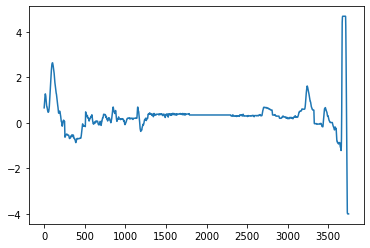

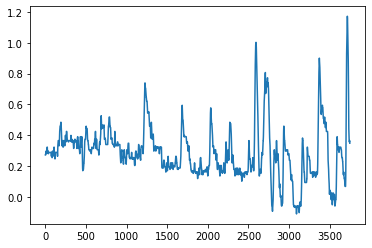

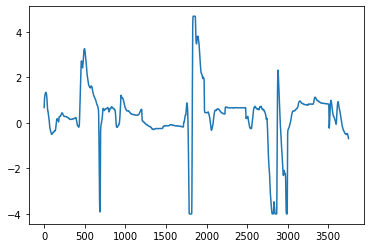

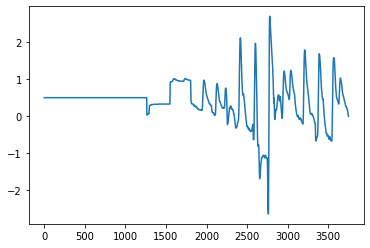

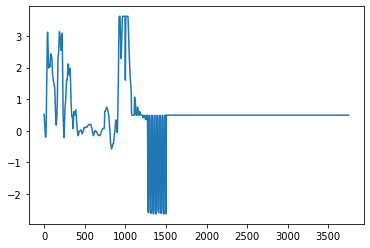

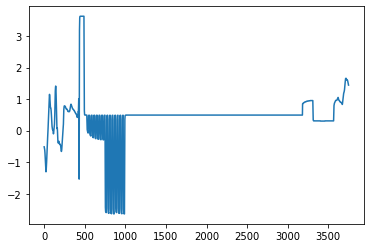

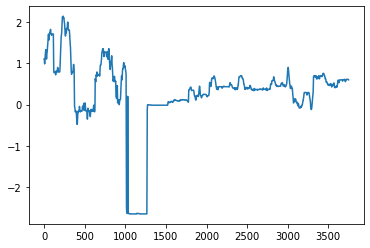

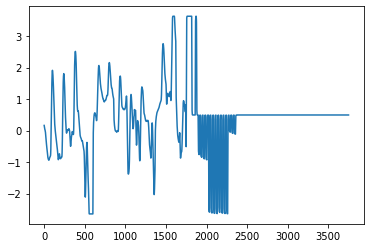

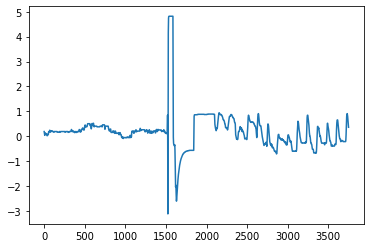

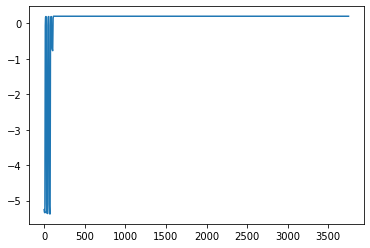

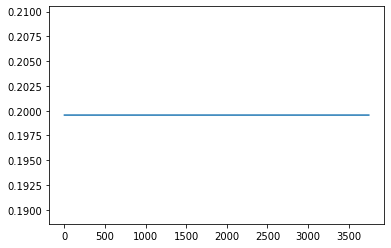

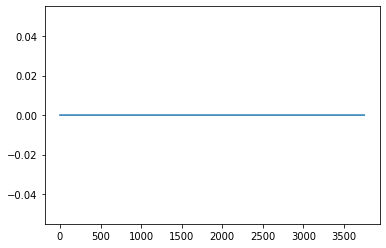

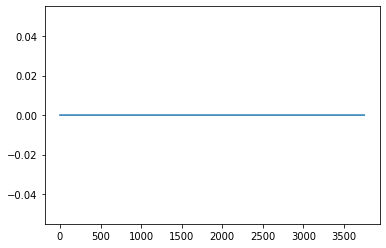

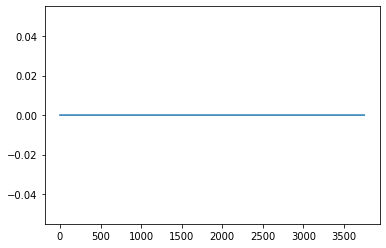

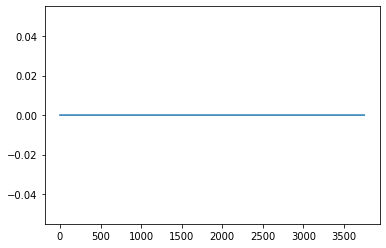

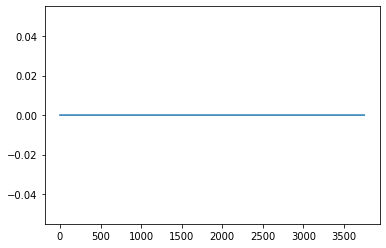

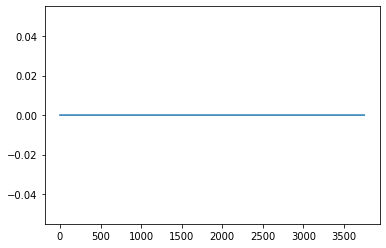

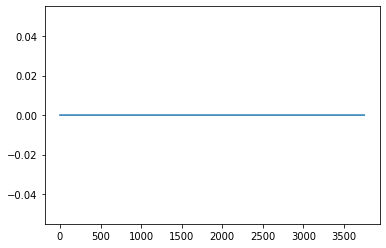

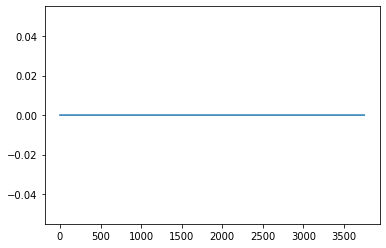

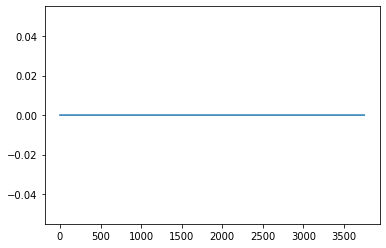

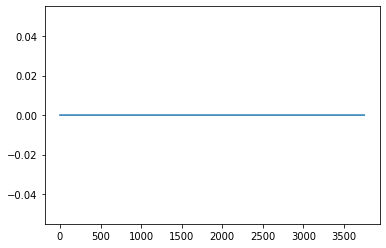

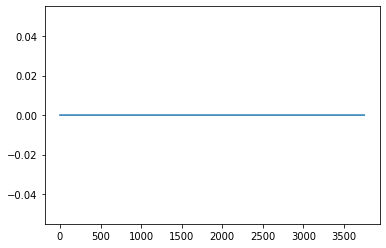

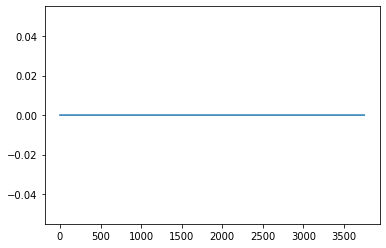

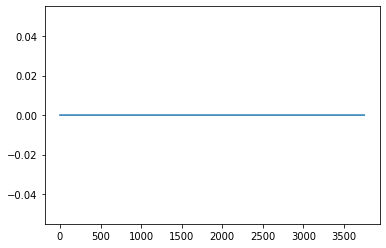

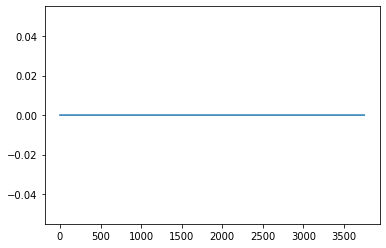

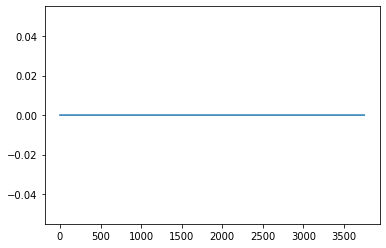

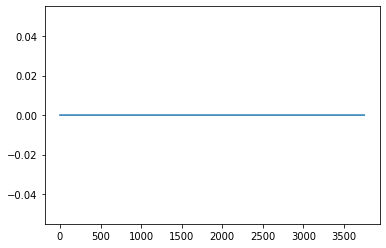

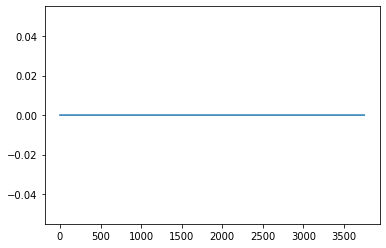

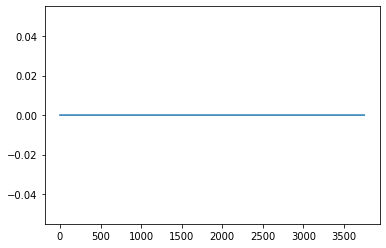

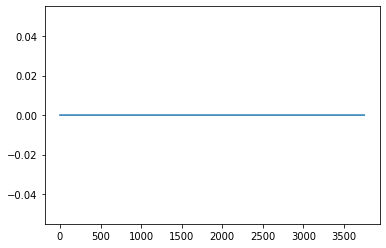

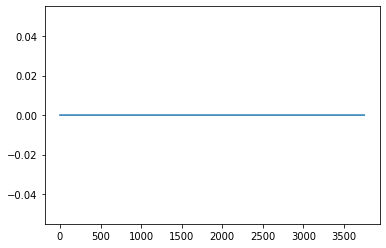

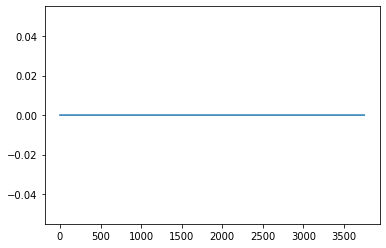

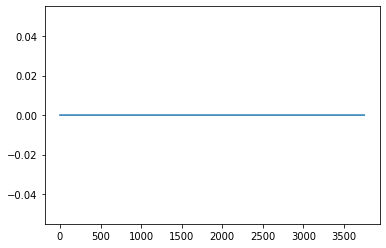

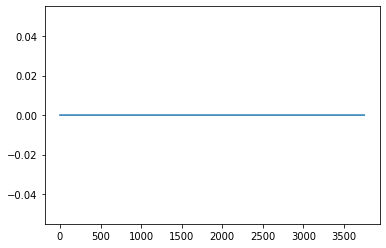

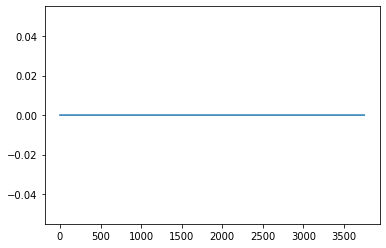

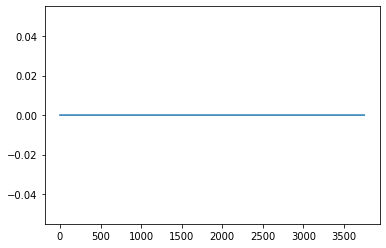

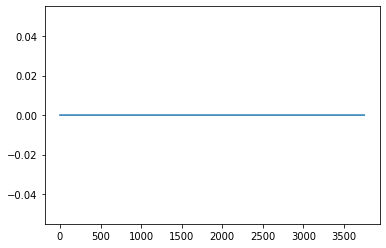

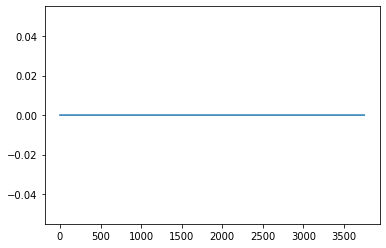

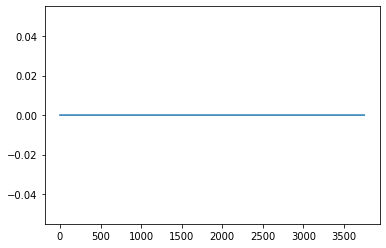

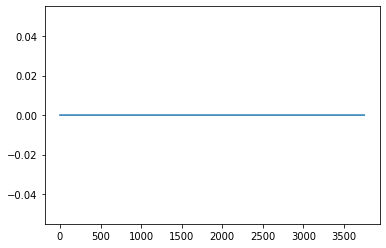

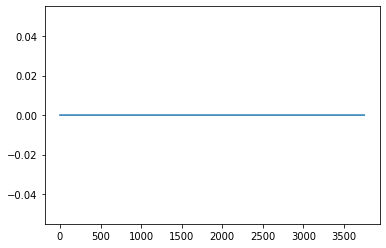

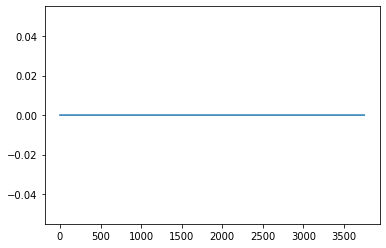

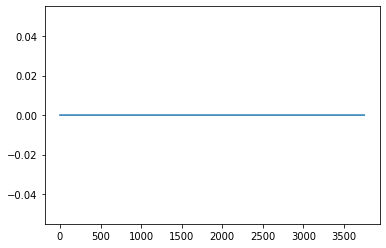

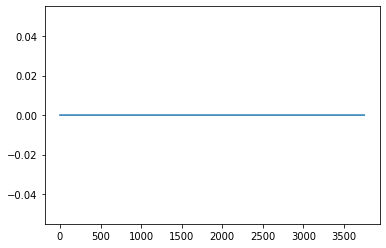

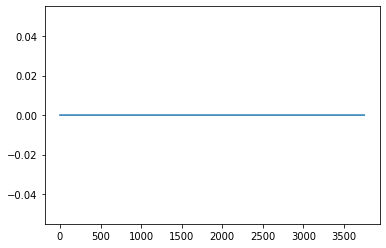

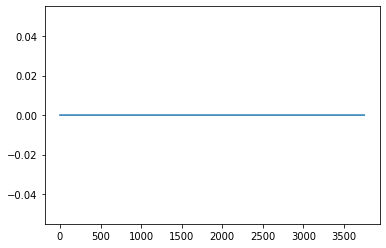

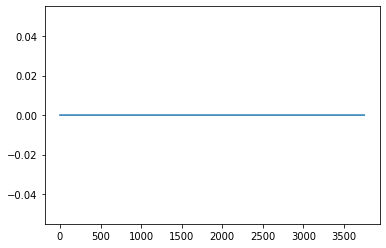

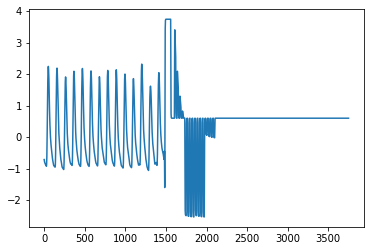

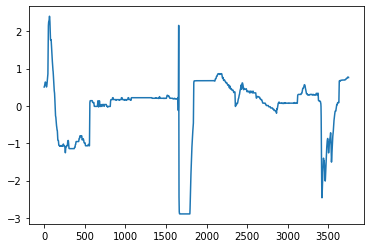

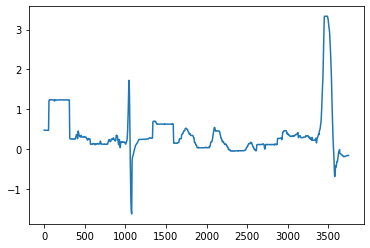

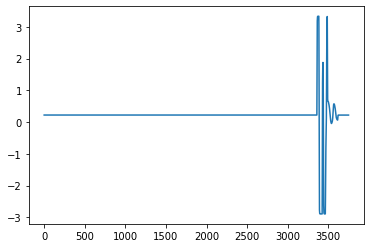

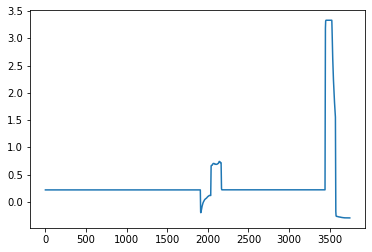

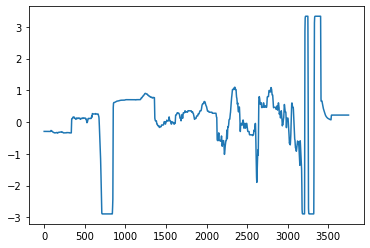

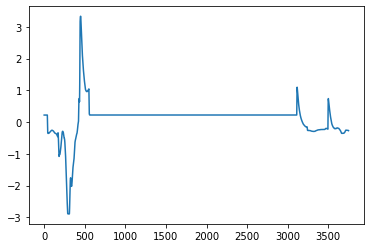

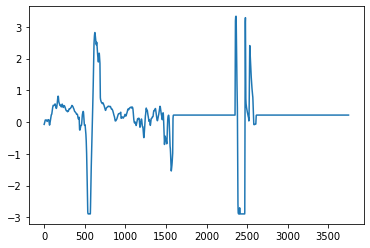

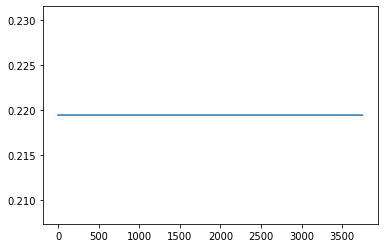

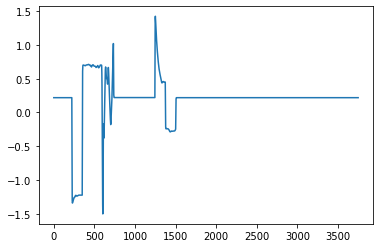

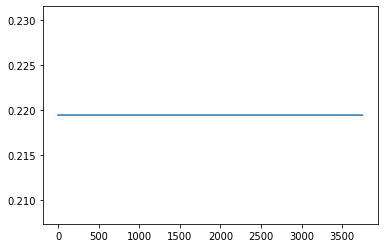

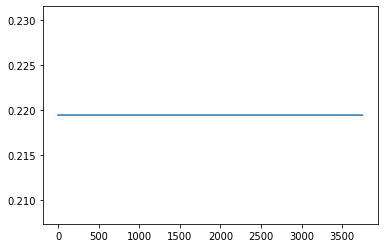

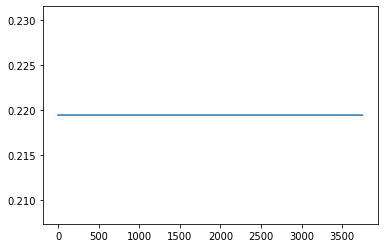

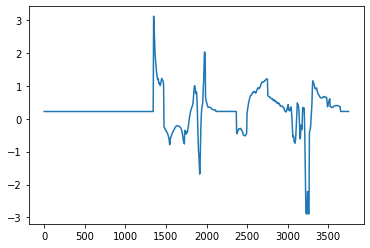

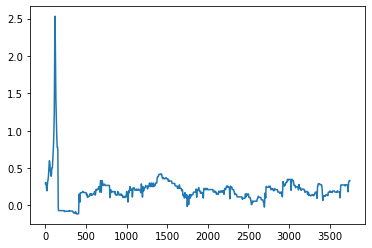

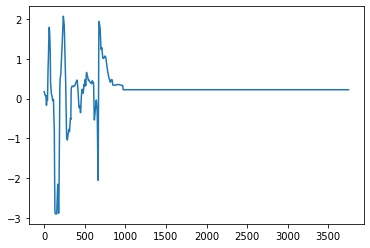

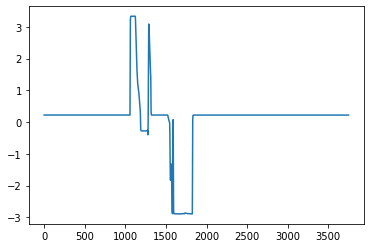

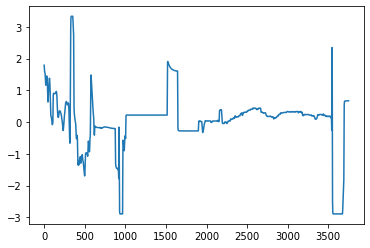

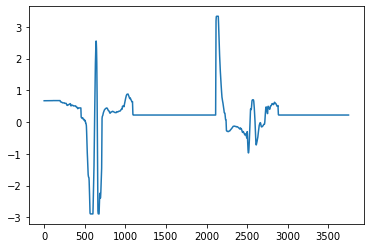

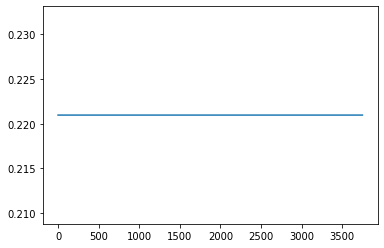

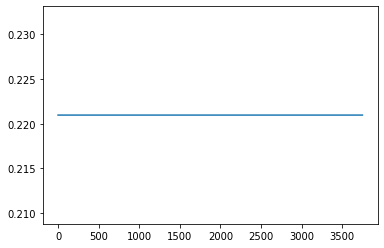

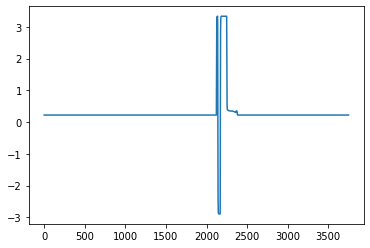

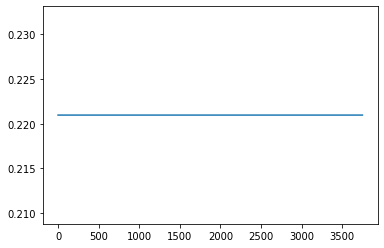

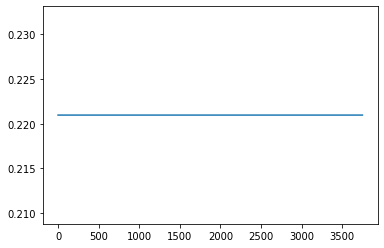

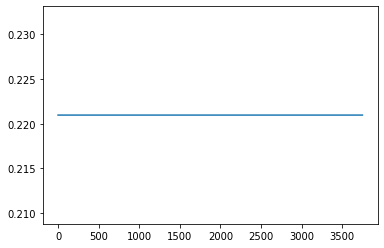

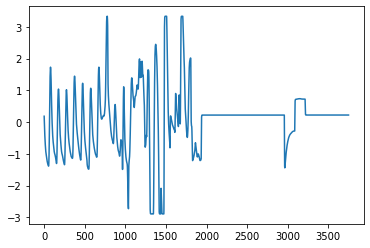

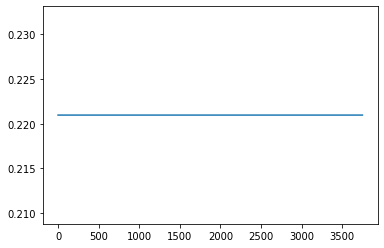

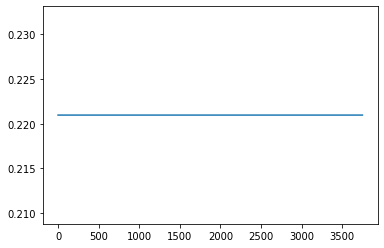

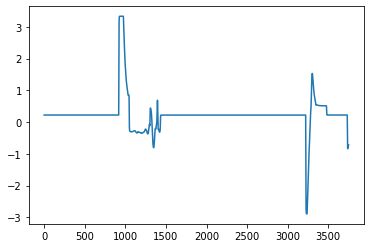

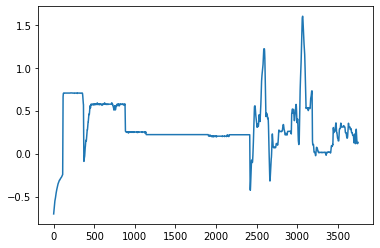

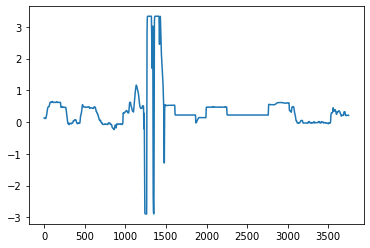

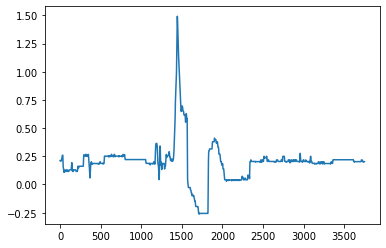

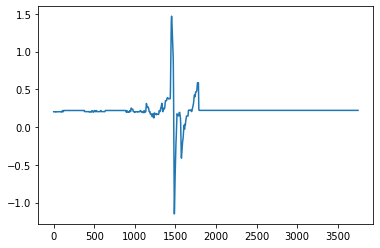

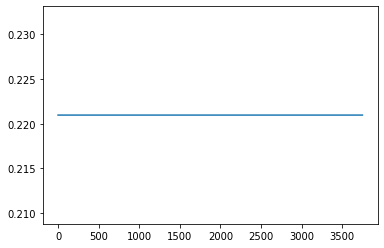

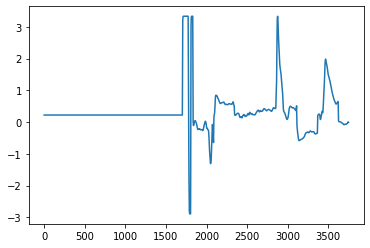

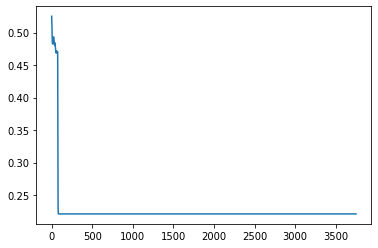

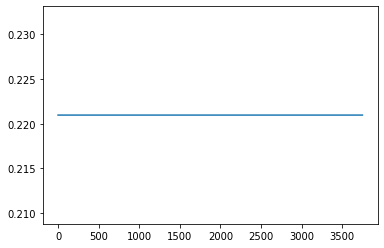

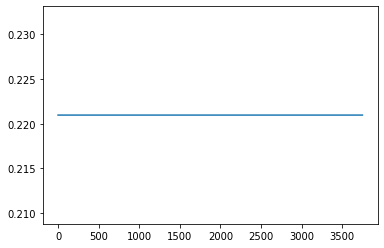

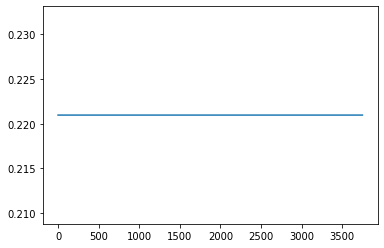

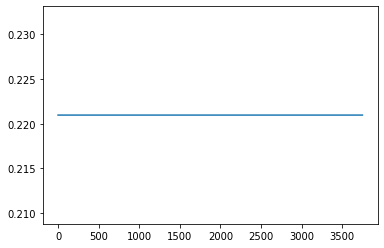

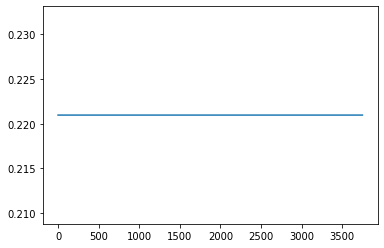

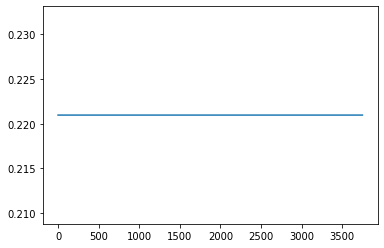

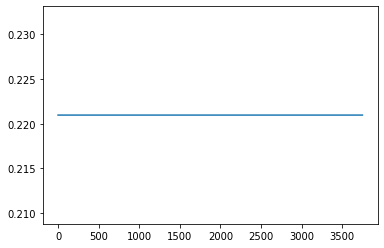

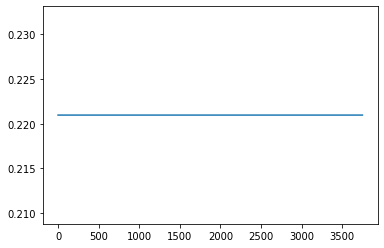

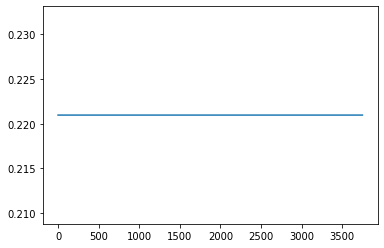

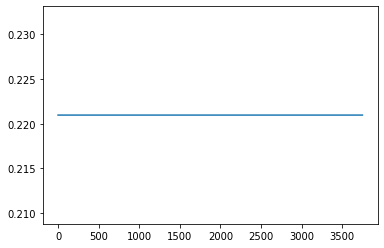

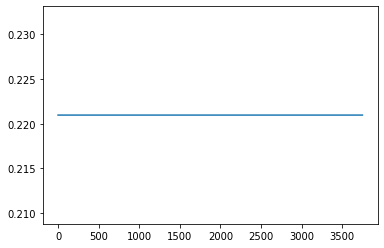

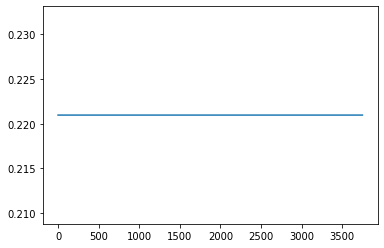

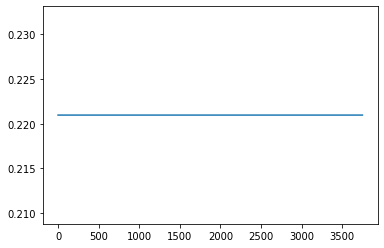

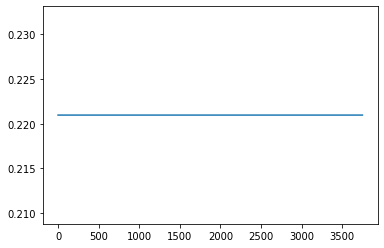

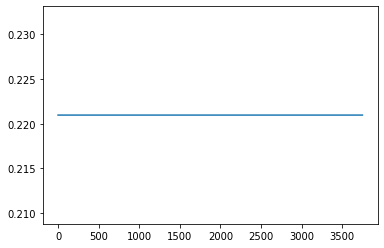

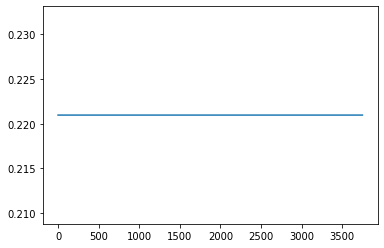

In [37]:
#take the fist 50 samples to see the rejected segements
for i in range(len(PPG_rm_list[:100])):
  x = PPG_rm_list[i]
  plt.figure()
  plt.plot(seg_PPG_signals[x])

####5.1.3.3 Remove flat PPG seg

In [0]:
#join the two lists rm_list from ECG, and PPG_rm_list
ECG_list = pd.DataFrame(rm_list)
PPG_list = pd.DataFrame(PPG_rm_list)
total_list = ECG_list.merge(PPG_list,how="outer")

In [108]:
removal_list=total_list.values.tolist()
cl_PPG_signals = np.delete(seg_PPG_signals,total_list,0)

numpy.ndarray

### 5.1.4 Band pass filter

In [0]:
bf_PPG_signals = []
for i in range(len(PPG_clean_signals)):
  bf_PPG_signal =butter_bandpass_filter(PPG_clean_signals[i],0.2,8,300,order=3)
  bf_PPG_signals.append(bf_PPG_signal)
print("After band pass filtering, there are:", len(bf_PPG_signals), "records")

In [0]:
plt.plot(PPG_clean_signals[1][:600],label="before band pass filtering")
plt.legend()
plt.figure()
plt.plot(bf_PPG_signals[1][:600], label="after band pass filtering")
plt.legend()

###5.1.5 Hampel filter

In [0]:
hf_PPG_signals=[]
for i in range(len(bf_PPG_signals)):
  if i%1000 == 0:
    print("hampel filering for", i+1, "th sample...")
  hf_PPG_signal, _ = hampel_filter_forloop(bf_PPG_signals[i], 6)
  hf_PPG_signals.append(hf_PPG_signal)
print("After Hample filtering, there are:", len(hf_PPG_signals), "records")

In [0]:
plt.plot(raw_PPG_signals[1][400:505], label = "before hampel filter")
plt.plot(bf_PPG_signals[1][400:505], label = "after hampel filter")
plt.legend()

##5.2 Save processed PPG data

In [0]:
with open('D:WFDB/matched/filtered_PPG_signals_p09.pkl', "wb") as fp:
  pickle.dump(signals, fp)

#6.Optional filters

##6.1 Resample PPG signals

In [0]:
#save segmented PPG signal
with open('D:WFDB//matched/seg_PPG_signals_p09.pkl', "wb") as fp:
  pickle.dump(signals, fp)

In [0]:
#use wfdb.resample
from wfdb import processing
resamp_PPG_signals = []
for i in range(len(ECG_signals)):
  resamp_PPG_signal, _ = wfdb.processing.resample_sig(raw_PPG_signals[i],125,300)
  resamp_PPG_signals.append(new_PPG_signal)
#apply filters before using DEEP-ECG to label it

In [0]:
plt.plot(resamp_PPG_signals[1][:180]*-1,label = "300Hz")
plt.plot(raw_PPG_signals[1][:180]*-1, label="125Hz")
plt.legend()

##6.2 Flip PPG signals

In [0]:
plt.plot(raw_ECG_signals

In [0]:
rev_PPG_signals = np.multiply(resamp_PPG_signals, -1)

In [0]:
print("After band pass filtering, there are:", len(rev_PPG_signals), "records")

In [0]:
plt.plot(resamp_PPG_signals[1][:180]*-1,label = "not flipped")
plt.plot(rev_PPG_signals[1][:180]*-1, label="flipped")
plt.legend()

##6.3 Flat peak
Use this for ABP waveform

# 7.Label ECG with Afib 


In [0]:
#load filtered ECG data
with open('D:WFDB/matched/filtered_ECG_signals_p09.pkl', "rb") as fp:
  signals = pickle.load(fp)

In [3]:
#expand signals dimension for training purpuse
signals = np.array(signals)
print('signals dim before resize', signals.shape)
signals = np.expand_dims(signals, axis=1)
signals = np.expand_dims(signals,axis=3)
print('signals dim after resize', signals.shape)

signals dim before resize (82181, 3750)
signals dim after resize (82181, 1, 3750, 1)


In [0]:
#load model
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data")
model = tf.keras.models.load_model('Deep_ECG_125Hz_Normal_Weight.h5')

In [0]:
prediction = model.predict(signals)

In [0]:
threshold = 0.1
pred = np.where(prediction > threshold, 1, 0)

In [14]:
unique,counts=np.unique(pred, return_counts=True)
print('There are', counts[0], 'Non-Afib')
print('There are', counts[1], 'Afib')

There are 53887 Non-Afib
There are 28294 Afib


In [0]:
np.savetxt('ECG_Afib_labels_p09_t01.csv',pred,fmt='%1.0f')